Generation 1 best fitness: 10192.27
Generation 2 best fitness: 19165.37
Generation 3 best fitness: 26490.83
Generation 4 best fitness: 27319.45
Generation 5 best fitness: 28378.75
Generation 6 best fitness: 28599.06
Generation 7 best fitness: 28603.02
Generation 8 best fitness: 26146.95
Generation 9 best fitness: 27273.83
Generation 10 best fitness: 26101.94
Generation 11 best fitness: 27061.24
Generation 12 best fitness: 27142.51
Generation 13 best fitness: 27178.64
Generation 14 best fitness: 25693.67
Generation 15 best fitness: 25351.95
Generation 16 best fitness: 26247.47
Generation 17 best fitness: 23440.11
Generation 18 best fitness: 23550.26
Generation 19 best fitness: 22219.81
Generation 20 best fitness: 23244.20

Optimal Angle: 73.86°, Optimal Thrust: 4636.79 N


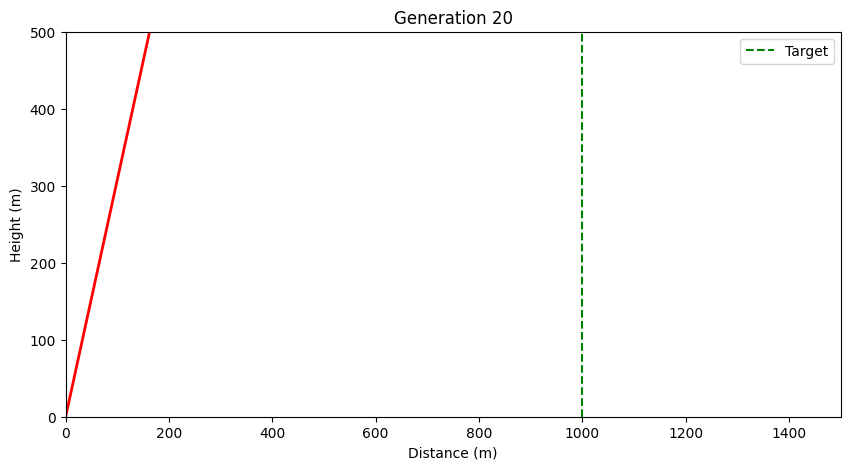

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from IPython.display import HTML, display

# ======= Physics Simulation =======
def simulate_trajectory(angle_deg, thrust, wind=False):
    g = 9.81
    mass = 50
    drag_coeff = 0.01
    burn_time = 10
    dt = 0.1
    time = np.arange(0, 100, dt)

    x, y = [0], [0]
    vx, vy = 0, 0

    for t in time[1:]:
        fx = 0
        fy = -mass * g

        if t <= burn_time:
            fx += thrust * np.cos(np.radians(angle_deg))
            fy += thrust * np.sin(np.radians(angle_deg))

        if wind:
            fx += np.random.normal(0, 10)

        fx -= drag_coeff * vx
        fy -= drag_coeff * vy

        ax = fx / mass
        ay = fy / mass

        vx += ax * dt
        vy += ay * dt

        x_new = x[-1] + vx * dt
        y_new = y[-1] + vy * dt

        if y_new < 0:
            break

        x.append(x_new)
        y.append(y_new)

    return np.array(x), np.array(y)

# ======= GA Parameters =======
POPULATION_SIZE = 30
GENERATIONS = 20
MUTATION_RATE = 0.1
TARGET_DISTANCE = 1000

trajectory_history = []

def fitness(ind):
    angle, thrust = ind
    x, y = simulate_trajectory(angle, thrust, wind=True)
    dist_err = abs(TARGET_DISTANCE - x[-1])
    penalty = 1000 if y[-1] < 0 else 0
    return dist_err + penalty

def create_individual():
    angle = random.uniform(30, 80)
    thrust = random.uniform(3000, 8000)
    return [angle, thrust]

def create_population():
    return [create_individual() for _ in range(POPULATION_SIZE)]

def crossover(p1, p2):
    return [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2], [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]

def mutate(ind):
    if random.random() < MUTATION_RATE:
        ind[0] += random.uniform(-2, 2)
        ind[1] += random.uniform(-300, 300)
        ind[0] = min(max(ind[0], 30), 80)
        ind[1] = min(max(ind[1], 3000), 8000)
    return ind

def genetic_algorithm():
    population = create_population()
    for gen in range(GENERATIONS):
        scored = [(fitness(ind), ind) for ind in population]
        scored.sort(key=lambda x: x[0])
        best = scored[0][1]
        print(f"Generation {gen+1} best fitness: {scored[0][0]:.2f}")
        x_best, y_best = simulate_trajectory(best[0], best[1], wind=True)
        trajectory_history.append((x_best, y_best))
        selected = [ind for (_, ind) in scored[:POPULATION_SIZE//2]]
        children = []
        while len(children) < POPULATION_SIZE:
            p1, p2 = random.sample(selected, 2)
            c1, c2 = crossover(p1, p2)
            children.append(mutate(c1))
            children.append(mutate(c2))
        population = children
    return scored[0][1]

best_angle, best_thrust = genetic_algorithm()
print(f"\nOptimal Angle: {best_angle:.2f}°, Optimal Thrust: {best_thrust:.2f} N")

# ======= Animation setup =======
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(TARGET_DISTANCE, color='green', linestyle='--', label='Target')
line, = ax.plot([], [], 'r-', lw=2)
ax.set_xlim(0, TARGET_DISTANCE + 500)
ax.set_ylim(0, 500)
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Height (m)")
ax.legend()

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x, y = trajectory_history[i]
    line.set_data(x, y)
    ax.set_title(f"Generation {i+1}")
    return (line,)

ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=len(trajectory_history),
                              interval=600,
                              blit=True)

# Save animation as HTML and display
html_anim = ani.to_jshtml()
display(HTML(html_anim))
